In [25]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import numpy as np

from apps import cex_analyse, cex_toy_generator, cex_toy_parameters
from python.analysis import cross_section, Plots, Fitting

from rich import print

cross_section.SetPlotStyle(True, dpi = 100)

def Analyse(analysis_input : cross_section.AnalysisInput, model : cross_section.pyhf.Model, args : cross_section.argparse.Namespace, energy_slices : cross_section.Slices, mean_track_score_bins : np.array):

    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, model)

    histograms_true_obs, histograms_reco_obs, histograms_reco_obs_err = cex_analyse.BackgroundSubtraction(analysis_input, args.signal_process, energy_slices, region_fit_result, None) #? make separate background subtraction function?

    unfolding_result = cex_analyse.Unfolding(histograms_reco_obs, histograms_reco_obs_err, energy_slices, args.toy_template, region_fit_result, args.signal_process, None)

    #* integrate into unfolding results
    n_incident_unfolded = cross_section.EnergySlice.NIncident(unfolding_result["init"]["unfolded"], unfolding_result["int"]["unfolded"])
    n_incident_unfolded_err = np.sqrt(unfolding_result["int"]["stat_err"]**2 + np.cumsum(unfolding_result["init"]["stat_err"]**2 + unfolding_result["int"]["stat_err"]**2))

    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
    xs = cross_section.EnergySlice.CrossSection(unfolding_result["int_ex"]["unfolded"][1:], unfolding_result["int"]["unfolded"][1:], n_incident_unfolded[1:], slice_dEdX, energy_slices.width, unfolding_result["int_ex"]["stat_err"][1:], unfolding_result["int"]["stat_err"][1:], n_incident_unfolded_err[1:])
    # Plots.plt.close("all")
    return xs


def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None, smearing : str = "double_crystal_ball", step : float = 2, beam_profile : str = "gaussian", max_cpus : int = 11):
    return {
    "events" : events,
    "step" : step,
    "p_init" : p_init,
    "beam_profile" : beam_profile,
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/{smearing}.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/{smearing}.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/{smearing}.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs,
    "max_cpus" : max_cpus
    }


def SysErr(nominal, modified):
    res = np.nan_to_num(nominal - modified)

    low = res > 0 # the nominal value is higher than the modified, so the change is small
    high = ~low
    
    err_low = abs(np.where(low, res, 0))
    err_high = abs(np.where(high, res, 0))

    return err_low, err_high


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


# Load data

In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/cex_analysis_1GeV_config.json"))
args.toy_template = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_cb_template.hdf5")

In [ ]:
energy_slices = cross_section.Slices(50, 0, 1050, True)
mean_track_score_bins = np.linspace(0, 1, 21, True)
model = cross_section.RegionFit.CreateModel(cross_section.AnalysisInput.CreateAnalysisInputToy(args.toy_template), energy_slices, mean_track_score_bins, False, None, False)

In [11]:
toy_dcb = cross_section.Toy(
    df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(1, 1000, int(5E6),
    seed = 1,
    smearing = "double_crystal_ball",
    step = 2,
    beam_profile = "work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    max_cpus = 6
    ))))

Simulating |████████████████████████████████████████| 84/84 [100%] in 2:37.9 (0.53/s) 


'BeamSelectionEfficiency' executed in 0.2686s

'GenerateRecoRegions' executed in 8.2742s

'MeanTrackScore' executed in 19.5938s

'main' executed in 202.0846s

In [12]:
def CreateNewAnalysisInput(toy : cross_section.Toy, new_smearing : cross_section.pd.DataFrame):
    new_smeared = cex_toy_generator.ApplySmearing(toy.df, new_smearing)
    analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)
    analysis_input.KE_init_reco = new_smeared.KE_init_smeared
    analysis_input.track_length_reco = new_smeared.z_int_smeared
    analysis_input.KE_int_reco = new_smeared.KE_int_smeared
    return analysis_input


smearing_params = {
    "KE_init" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_init/double_crystal_ball.json"),
    "KE_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int/double_crystal_ball.json"),
    "z_int" : cross_section.LoadConfiguration("/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/z_int/double_crystal_ball.json")
    }

p_high = {}
p_low = {}
for i, j in smearing_params.items():
    p_high[i] = {k : j["values"][k] + j["errors"][k] for k in j["values"]}
    p_low[i] = {k : j["values"][k] - j["errors"][k] for k in j["values"]}

smearing = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_dcb.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), v["values"], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})

In [13]:
analysis_input_nominal = CreateNewAnalysisInput(toy_dcb, smearing)

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-3046845.07869213])
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.50102668, 0.49370255, 0.49708265, 0.51254672])
uncertainty=array([0.00103647, 0.00171104, 0.0011832 , 0.00303676])


using KE_int,ex from region fit

signal: charge_exchange

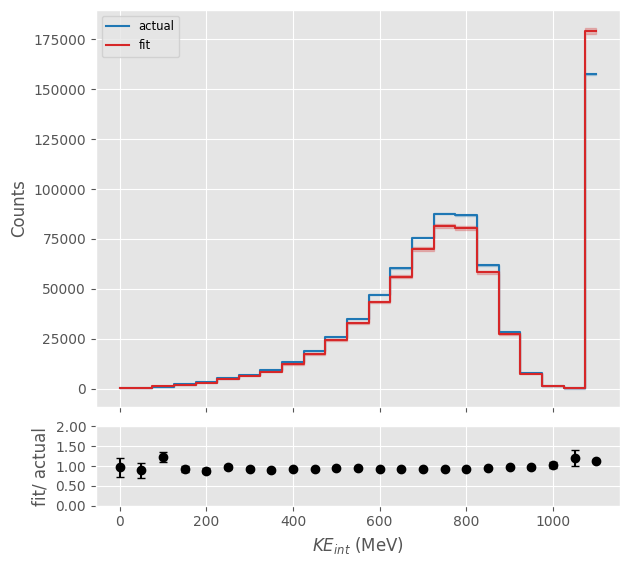

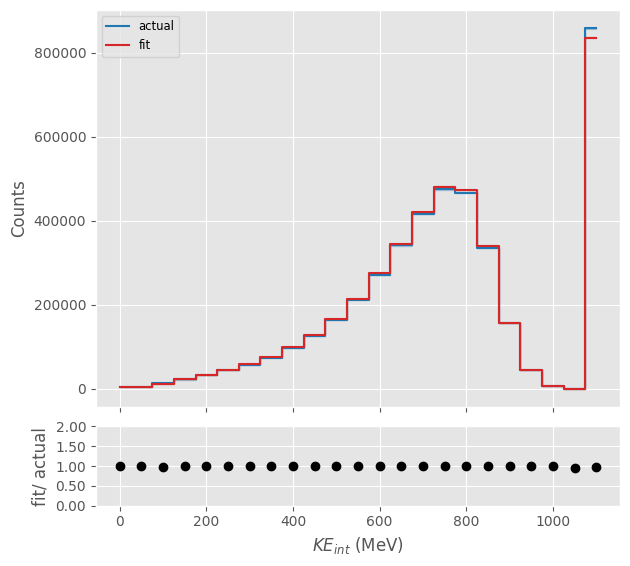

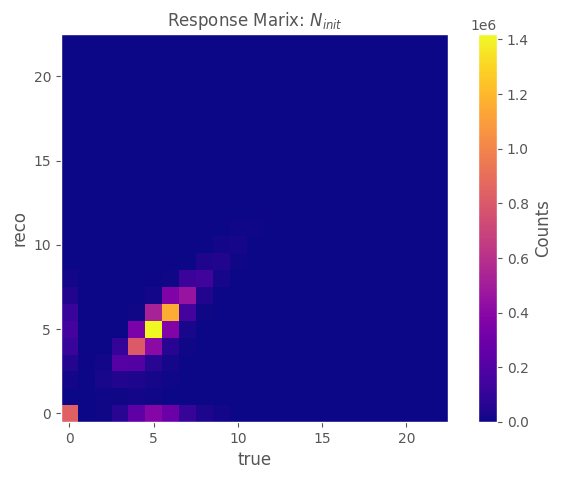

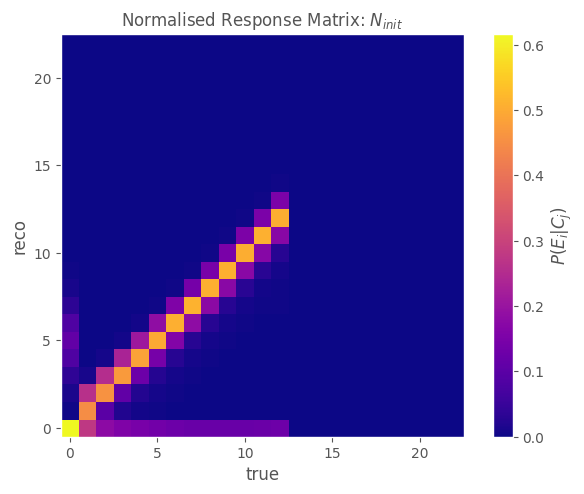

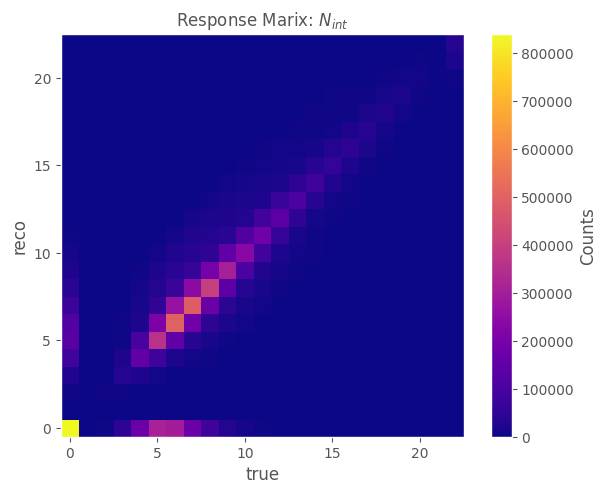

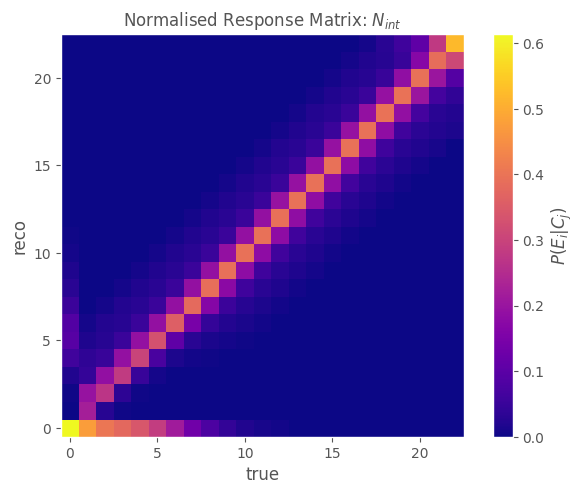

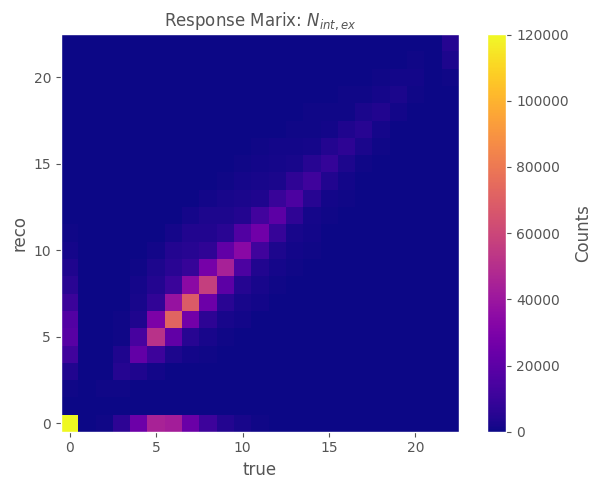

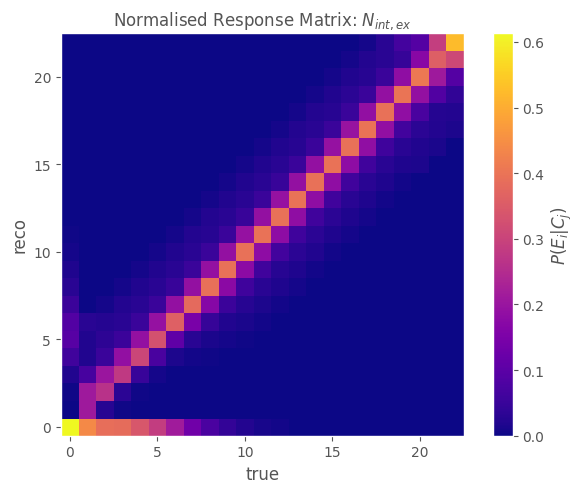

In [15]:
xs_nominal = Analyse(analysis_input_nominal, model, args, energy_slices, mean_track_score_bins)

# Detector parameterisation systematic

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-3046761.33032621])
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.50039088, 0.49182657, 0.49622049, 0.51792956])
uncertainty=array([0.00104863, 0.00175823, 0.00120662, 0.00312268])


using KE_int,ex from region fit

signal: charge_exchange

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-3047024.86302123])
poi_ind=[0, 1, 2, 3]
parameter=['mu_0', 'mu_1', 'mu_2', 'mu_3']
bestfit=array([0.50142167, 0.49603865, 0.4982788 , 0.50627235])
uncertainty=array([0.00103336, 0.00170469, 0.00117786, 0.00302302])


using KE_int,ex from region fit

signal: charge_exchange

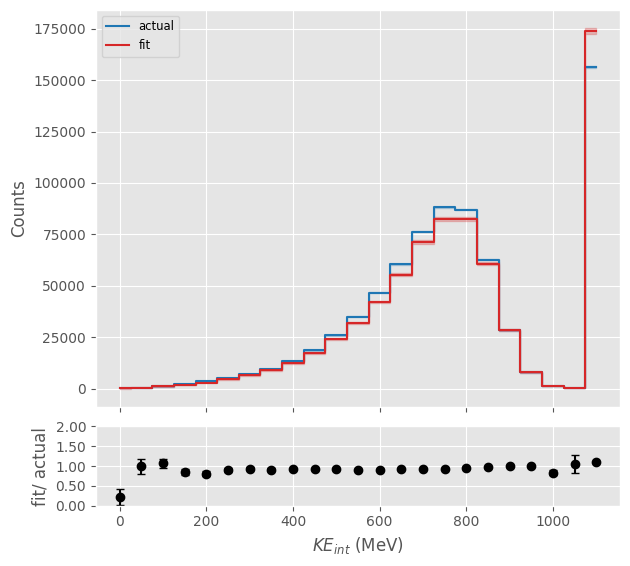

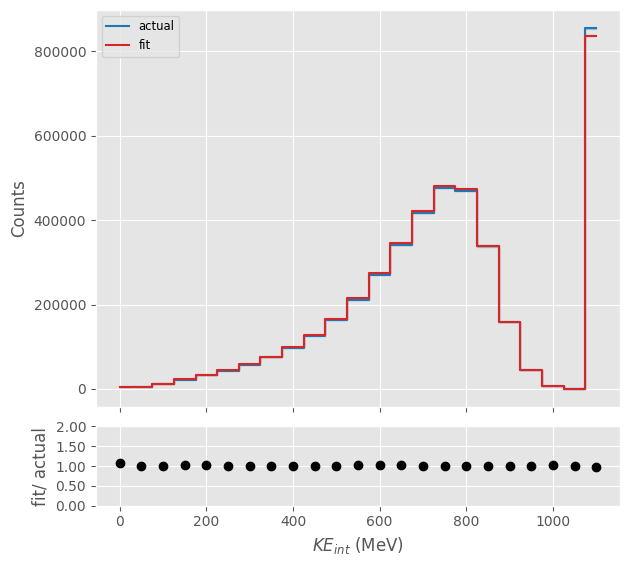

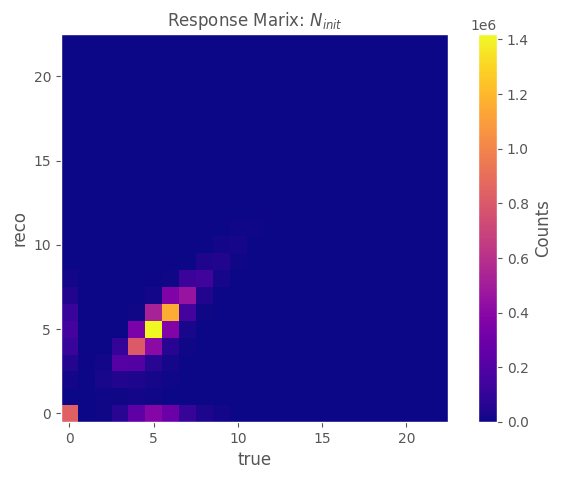

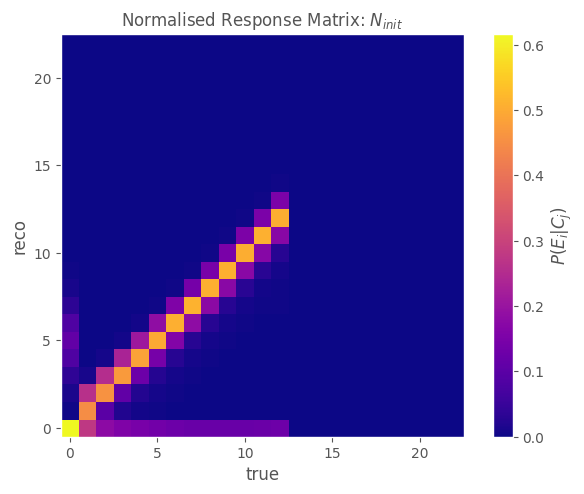

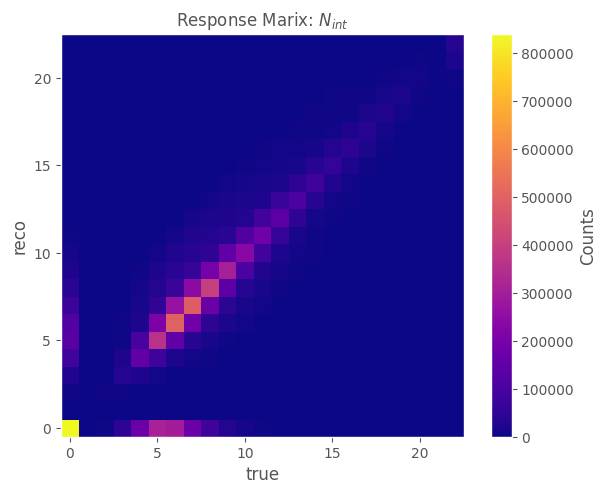

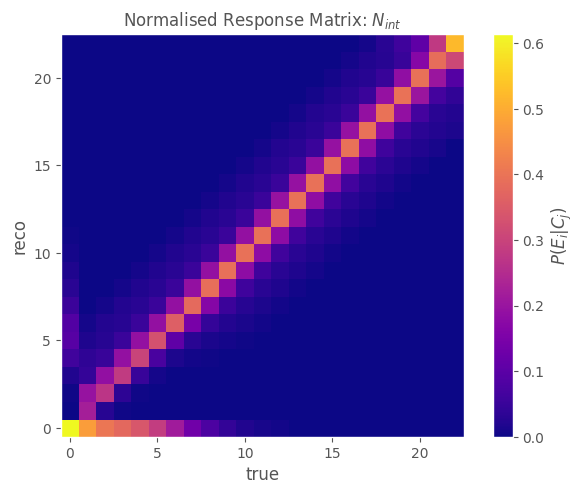

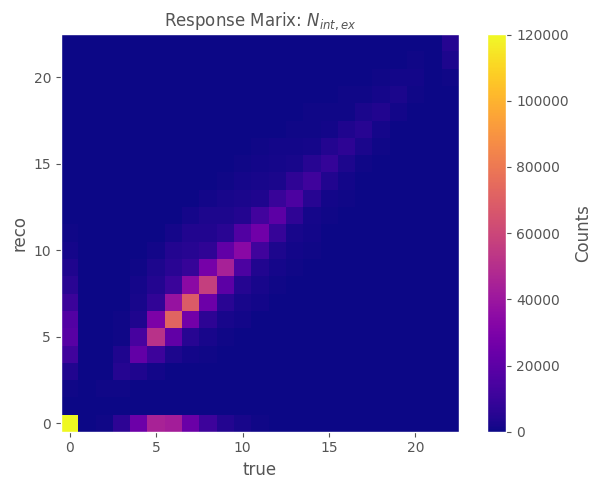

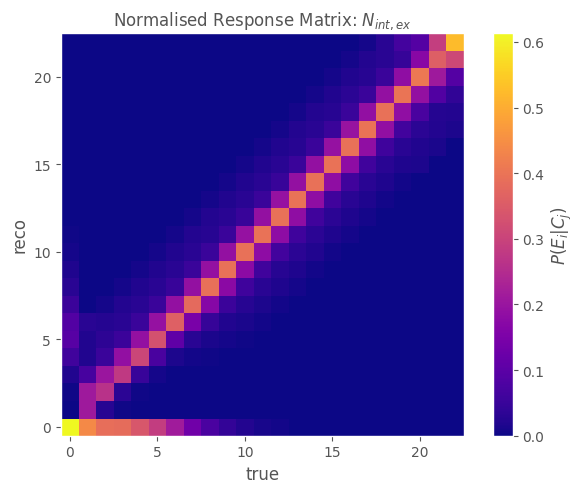

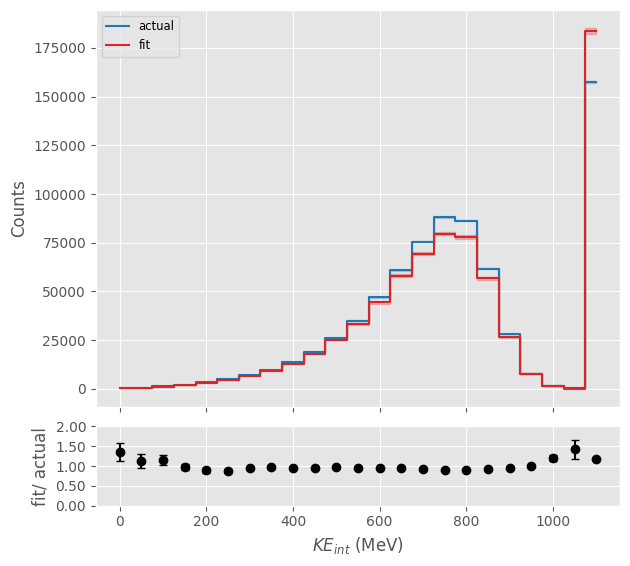

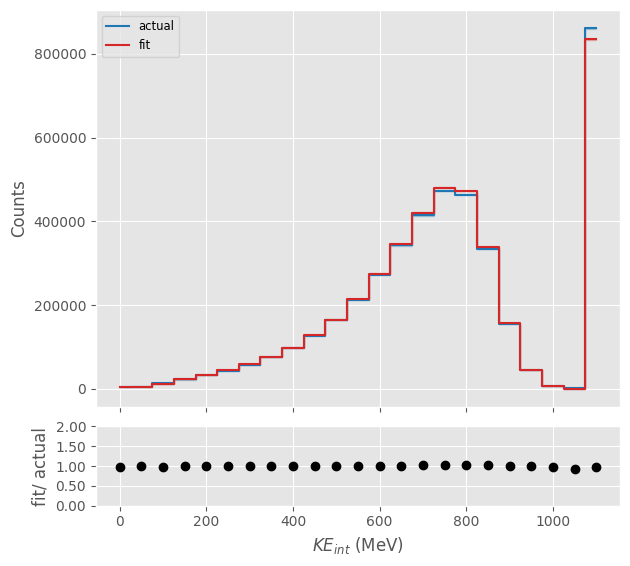

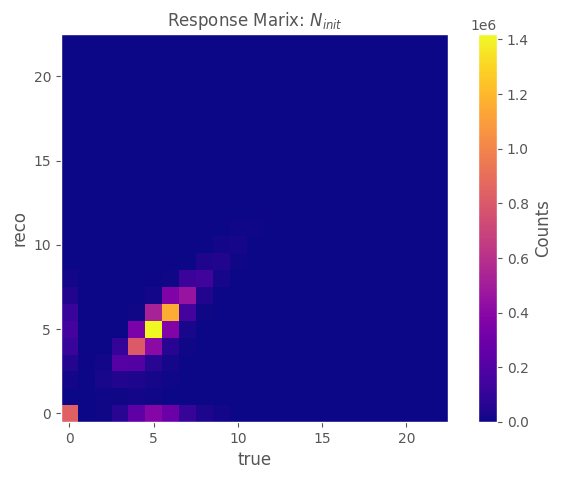

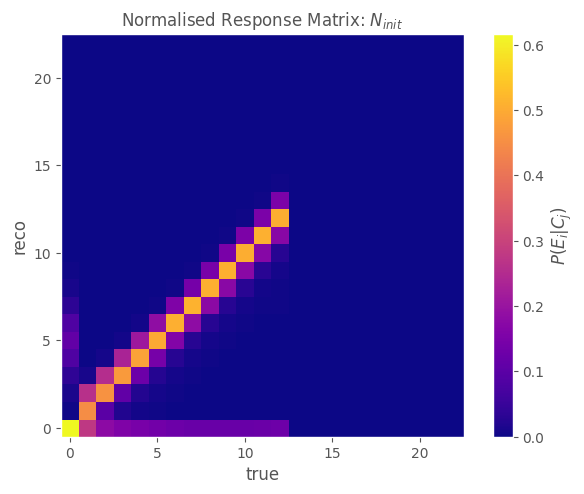

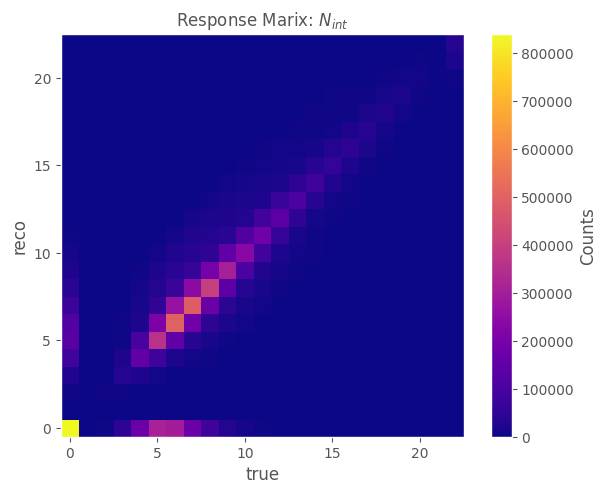

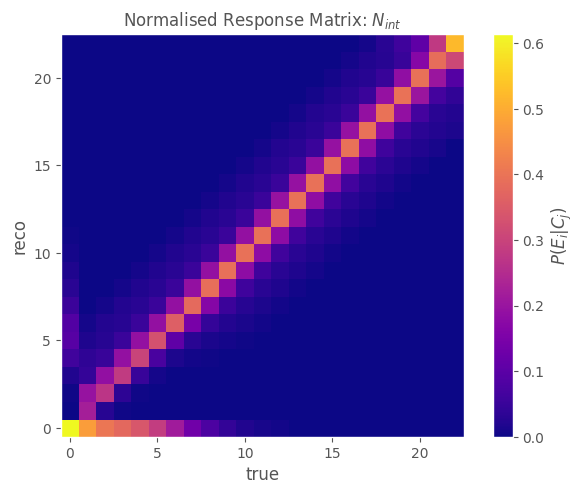

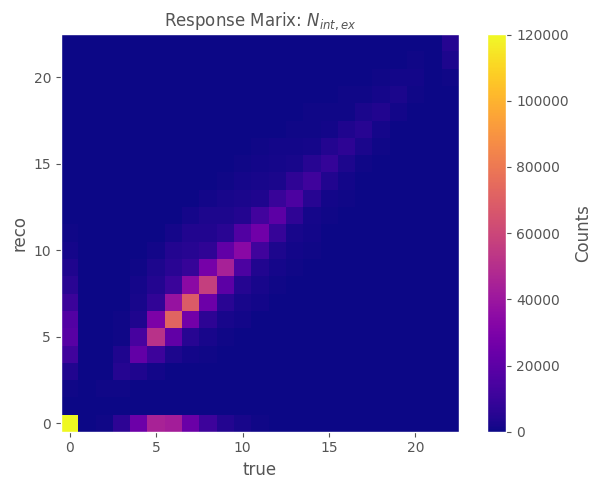

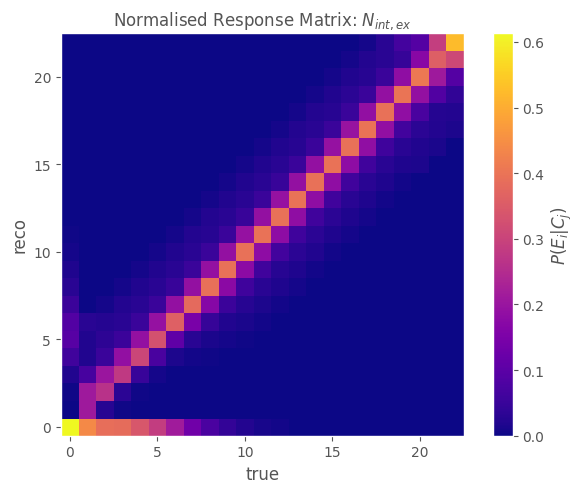

In [19]:
smearing_high = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_dcb.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_high[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
smearing_low = cross_section.pd.DataFrame({f"{k}_smearing" : cross_section.Fitting.RejectionSampling(len(toy_dcb.df), min(v["range"]), max(v["range"]), getattr(cross_section.Fitting, v["function"]), p_low[k], rng = np.random.default_rng(1)) for k, v in smearing_params.items()})
analysis_input_high = CreateNewAnalysisInput(toy_dcb, smearing_high)
analysis_input_low = CreateNewAnalysisInput(toy_dcb, smearing_low)

xs_high = Analyse(analysis_input_high, model, args, energy_slices, mean_track_score_bins)
xs_low = Analyse(analysis_input_low, model, args, energy_slices, mean_track_score_bins)

In [50]:
book = Plots.PlotBook("detector_sys_5E6.pdf", True)

pdf detector_sys_5E6.pdf has been opened


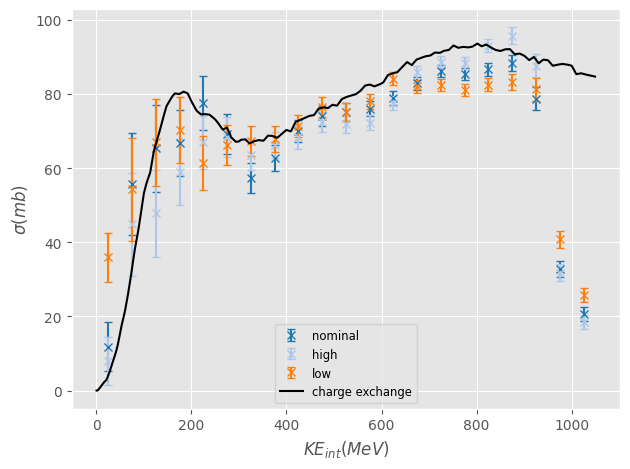

In [51]:
geant_xs = cross_section.GeantCrossSections(energy_range = [0, 1050])

Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "nominal")
Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_high[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "high", newFigure = False)
Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_low[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "low", newFigure = False)
geant_xs.Plot("charge_exchange", color = "k")
book.Save()

(
    array([ 0.        ,  0.        ,  0.        ,  5.11418772,  4.20466064,
        4.45394424,  3.78373983,  0.73133016,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.89183509, 16.021676  ,  0.        ,  0.        ,  1.54191368,
        0.        ,  0.        ]),
    array([5.20776227e+00, 8.05386503e+00, 2.50725379e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.13337441e+00, 2.03546780e+00, 2.42436579e-04, 2.36702643e+00,
       1.33925047e+00, 5.06736442e+00, 1.00026996e+01, 0.00000000e+00,
       0.00000000e+00, 3.44002002e+00, 1.64055841e+00, 0.00000000e+00,
       2.40838971e+01, 0.00000000e+00])
)

pdf detector_sys_5E6.pdf has been closed


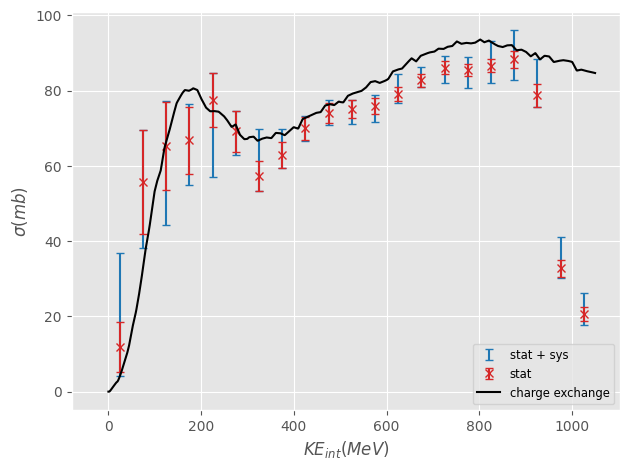

In [52]:
def quadsum(*arg):
    return np.sqrt(sum([a**2 for a in arg]))

err_high_var = SysErr(xs_nominal[0], xs_high[0])
err_low_var = SysErr(xs_nominal[0], xs_low[0])

sys_err_low = quadsum(err_low_var[0], err_high_var[0])
sys_err_high = quadsum(err_low_var[1], err_high_var[1])

print(err_low_var)

total_err_low = quadsum(xs_nominal[1], sys_err_low)
total_err_high = quadsum(xs_nominal[1], sys_err_high)

Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = (total_err_low, total_err_high), linestyle = "", marker = "", label = "stat + sys", newFigure = False)
# Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = (sys_err_low, sys_err_high), linestyle = "", marker = "", label = "sys", newFigure = False)
Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_nominal[0], yerr = xs_nominal[1], linestyle = "", marker = "x", label = "stat", color = "C6", newFigure = False)
geant_xs.Plot("charge_exchange", "k")
book.Save()
book.close()